In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

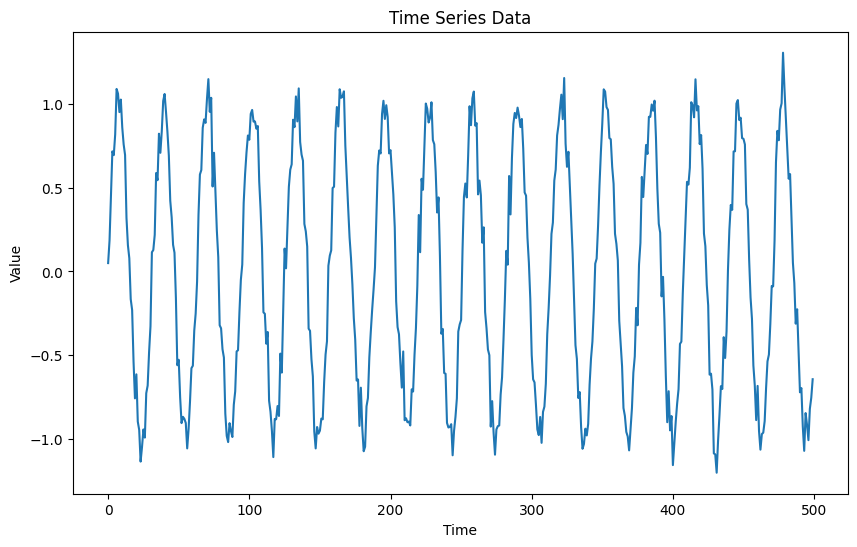

In [2]:
# 데이터 생성 (임의의 시계열 데이터)
np.random.seed(42)
data = np.sin(np.linspace(0, 100, 500)) + np.random.normal(0, 0.1, 500)

# 데이터프레임 생성
df = pd.DataFrame(data, columns=['value'])

# 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(df['value'])
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [3]:
# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
df['value'] = scaler.fit_transform(df['value'].values.reshape(-1, 1))

# 시퀀스 생성
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(df['value'].values, seq_length)

# 학습/테스트 데이터 분할
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, num_heads=8, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.input_projection = nn.Linear(input_size, hidden_size)
        
    def forward(self, x):
        x = self.input_projection(x)
        x = x.permute(1, 0, 2)  # Transformer expects input shape (seq_length, batch_size, hidden_size)
        out = self.transformer_encoder(x)
        out = out.mean(dim=0)  # Aggregate sequence outputs (e.g., by taking the mean)
        out = self.fc(out)
        return out


In [5]:
# 학습 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs, scheduler=None):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(-1)  # Add feature dimension
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 평가 함수
def evaluate_model(model, test_loader, scaler):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(-1)  # Add feature dimension
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(actuals.reshape(-1, 1))
    mse = mean_squared_error(actuals, predictions)
    return mse, actuals, predictions

In [6]:
# 모델 학습 및 평가
input_size = 1
hidden_size = 64  # Update hidden_size to be divisible by num_heads
output_size = 1
num_epochs = 100  # Increase the number of epochs
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {
    'RNN': RNNModel(input_size, hidden_size, output_size).to(device),
    'LSTM': LSTMModel(input_size, hidden_size, output_size).to(device),
    'GRU': GRUModel(input_size, hidden_size, output_size).to(device),
    'Transformer': TransformerModel(input_size, hidden_size, output_size, num_layers=3, num_heads=8, dropout=0.1).to(device)
}

criterion = nn.MSELoss()

results = {}
predictions_dict = {}

for model_name, model in models.items():
    print(f'Training {model_name} model...')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    train_model(model, train_loader, criterion, optimizer, num_epochs, scheduler)
    mse, actuals, predictions = evaluate_model(model, test_loader, scaler)
    results[model_name] = mse
    predictions_dict[model_name] = predictions
    print(f'{model_name} model MSE: {mse:.4f}')

SyntaxError: incomplete input (967362554.py, line 26)

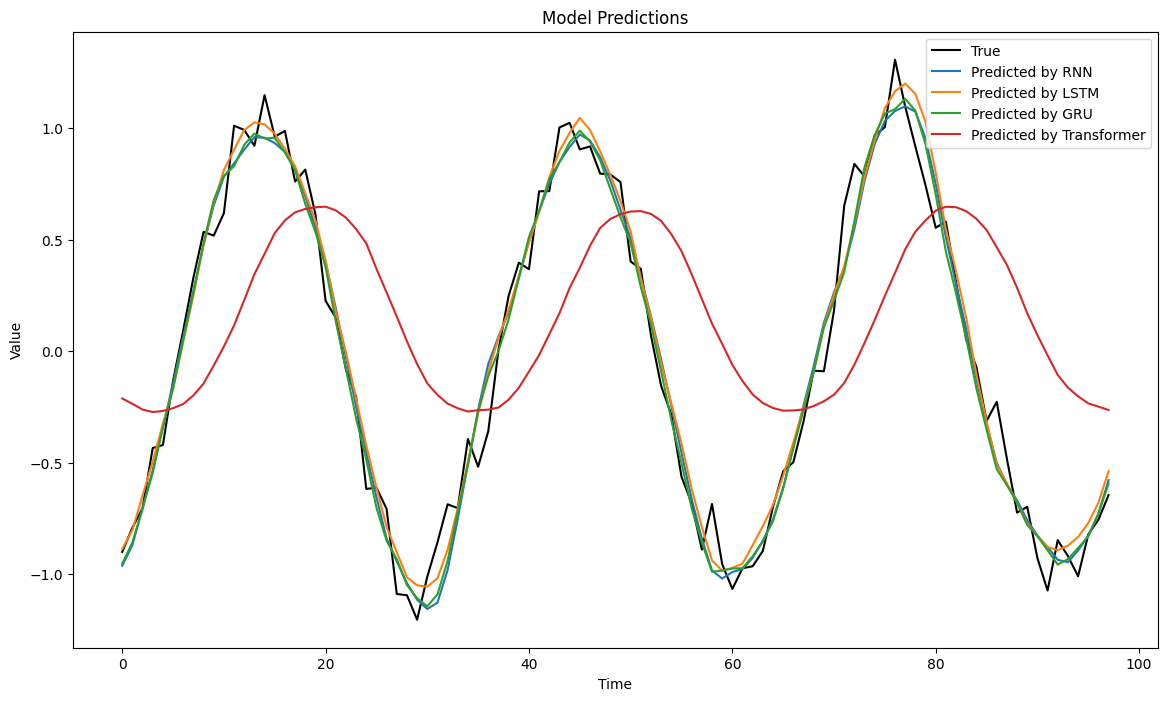

Mean Squared Error (MSE) for each model:
RNN: 0.01514506433159113
LSTM: 0.0145814074203372
GRU: 0.014447471126914024
Transformer: 0.43955492973327637


In [ ]:
# 예측 결과 시각화
plt.figure(figsize=(14, 8))
plt.plot(actuals, label='True', color='black')
for model_name, predictions in predictions_dict.items():
    plt.plot(predictions, label=f'Predicted by {model_name}')
plt.title('Model Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# 결과 비교
print("Mean Squared Error (MSE) for each model:")
for model_name, mse in results.items():
    print(f'{model_name}: {mse}')